# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

### Вспомогательные функции

In [2]:
def boxplot_plotter(data):
    fig = plt.figure(figsize = (15, 15))
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(234)
    ax4 = fig.add_subplot(235)
    ax5 = fig.add_subplot(233)
    ax6 = fig.add_subplot(236)


    ax1.boxplot(data['RegistrationYear'])
    ax1.set_title('Год регистрации')

    ax2.boxplot(data['Power'])
    ax2.set_title('Мощность')

    ax3.boxplot(data['RegistrationYear'])
    ax3.set_ylim((1950, 2025))
    ax3.set_title('Год регистрации (увел.)')

    ax4.boxplot(data['Power'])
    ax4.set_ylim((-50, 400))
    ax4.set_title('Мощность (увел.)')
    
    ax5.boxplot(data['Price'])
    ax5.set_title('Цена')
    
    ax6.boxplot(data['Price'])
    ax6.set_ylim((14000, 20000))
    ax6.set_title('Цена (увел.)')

    plt.show()

In [3]:
def data_plotter(data):
    fig = plt.figure(figsize = (20, 20))
    ax1 = fig.add_subplot(431)
    ax2 = fig.add_subplot(432)
    ax3 = fig.add_subplot(433)
    ax4 = fig.add_subplot(434)
    ax5 = fig.add_subplot(435)
    ax6 = fig.add_subplot(436)
    ax7 = fig.add_subplot(437)
    ax8 = fig.add_subplot(438)
    ax9 = fig.add_subplot(439)
    ax10 = fig.add_subplot(4, 3, 10)
    ax11 = fig.add_subplot(4, 3, 11)


    ax1.set_title('Дата скачивания анкеты')
    ax1.hist(data['DateCrawled'], bins = 50, color = 'black', alpha = 0.75)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(6))

    ax2.set_title('Цена')
    ax2.hist(data['Price'], bins = 50, color = 'black', alpha = 0.75)

    vehicle_types_pivot = pd.pivot_table(data = data, index = 'VehicleType', values = 'DateCrawled', aggfunc = 'count').reset_index()
    ax3.set_title('Тип кузова')
    ax3.pie(vehicle_types_pivot['DateCrawled'])
    ax3.legend(labels = vehicle_types_pivot['VehicleType'], loc = 'best')
    del vehicle_types_pivot

    ax4.set_title('Год регистрации')
    ax4.hist(data['RegistrationYear'], color = 'black', alpha = 0.75, range = (1980, 2020))

    gearbox_pivot = pd.pivot_table(data = data, index = 'Gearbox', values = 'DateCrawled', aggfunc = 'count').reset_index()
    ax5.set_title('Тип КПП')
    ax5.pie(gearbox_pivot['DateCrawled'], labels = gearbox_pivot['Gearbox'], autopct='%.1f%%')
    del gearbox_pivot

    ax6.set_title('Мощность')
    ax6.hist(data['Power'], bins = 100, color = 'black', alpha = 0.75, range = (0, 600))

    ax7.set_title('Пробег')
    ax7.hist(data['Kilometer'], bins = 20, color = 'black', alpha = 0.75)

    reg_month_pivot = pd.pivot_table(data = data, index = 'RegistrationMonth', values = 'DateCrawled', aggfunc = 'count').reset_index()
    ax8.set_title('Месяц регистрации')
    ax8.bar(reg_month_pivot['RegistrationMonth'], height = reg_month_pivot['DateCrawled'], color = 'black', alpha = 0.75)
    del reg_month_pivot

    fuel_type_pivot = pd.pivot_table(data = data, index = 'FuelType', values = 'DateCrawled', aggfunc = 'count').reset_index()
    ax9.set_title('Тип топлива')
    ax9.bar(fuel_type_pivot['FuelType'], fuel_type_pivot['DateCrawled'], color = 'black', alpha = 0.75)
    del fuel_type_pivot

    repaired_pivot = pd.pivot_table(data = data, index = 'Repaired', values = 'DateCrawled', aggfunc = 'count').reset_index()
    ax10.set_title('Ремонт')
    ax10.pie(repaired_pivot['DateCrawled'], labels = repaired_pivot['Repaired'], autopct='%.1f%%')
    del repaired_pivot

    ax11.set_title('Количество фото')
    ax11.hist(data['NumberOfPictures'], color = 'black', alpha = 0.75, range = (0, 10))

    plt.show()

In [4]:
def iqr_filter(df:pd.DataFrame, column:str):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    return df[(df[column] >= q1 - 1.5 * iqr ) & (df[column] <= q3 + 1.5 * iqr)]

In [5]:
def RMSE(target, predict):
    rmse = math.sqrt(mean_squared_error(target, predict))
    #print ('RMSE:', rmse)
    return rmse

In [6]:
def power_modder(df, trs1, trs2):
    df_copy = df.copy()
    df_copy['Power'].loc[(df['Power'] > trs1) & (df['Power'] < trs2)] = \
    df.loc[(df['Power'] > trs1) & (df['Power'] < trs2)]['Power'] / 10
    
    df_copy['Power'].loc[(df['Power'] > trs2)] = \
    df.loc[(df['Power'] > trs2)]['Power'] / 100
    
    return df_copy

In [7]:
def power_pivot_maker(df, trs):
    pd.set_option('display.max_rows', 100)

    power_treshold = trs
    data_power_treshold = df.loc[df['Power'] >= power_treshold]
    print('Автомобилей мощностью выше', power_treshold, 'в датасете:', data_power_treshold.shape[0])
    power_treshold_pivot = pd.pivot_table(data = data_power_treshold, index = 'Model', values = 'Power', aggfunc = 'max')
    display(power_treshold_pivot.sort_values('Power', ascending = True))

In [8]:
def registration_year_cutter(df, trs):
    df_copy = df.copy()
    df_copy = df.loc[df['RegistrationYear'] <= trs]
    return df_copy

In [9]:
def price_pivot_maker(df, trs):
    pd.set_option('display.max_rows', 500)

    price_treshold = trs
    data_price_treshold = df.loc[(df['Price'] <= price_treshold) & (df['Price'] >= 0)]
    price_treshold_pivot = pd.pivot_table(data = data_price_treshold, 
                                          index = 'Model', 
                                          values = ['Price'], 
                                          aggfunc = ['min','max', 'count'])
    return price_treshold_pivot

In [10]:
def price_cutter(df, trs):
    df_copy = df.copy()
    df_copy = df.loc[df['Price'] >= trs]
    return df_copy

### Загрузка файла с данными

In [11]:
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/11. Численные методы/Проект/autos.csv'
path_2 = 'https://code.s3.yandex.net/datasets/autos.csv'
path_3 = 'C:/Users/bodrenkov_ia/Desktop/Project/autos.csv'
path_4 = '/datasets/autos.csv'

if os.path.exists(path_1):
    data = pd.read_csv(path_1, sep = ',')
elif os.path.exists(path_2):
    data = pd.read_csv(path_2, sep = ',')
elif os.path.exists(path_3):
    data = pd.read_csv(path_3, sep = ',')
elif os.path.exists(path_4):
    data = pd.read_csv(path_4, sep = ',')
else:
    print('Что-то пошло не так!')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [13]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Изменение типов значений

In [14]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format = '%Y-%m-%d %H:%M:%S')

### Анализ данных

In [15]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


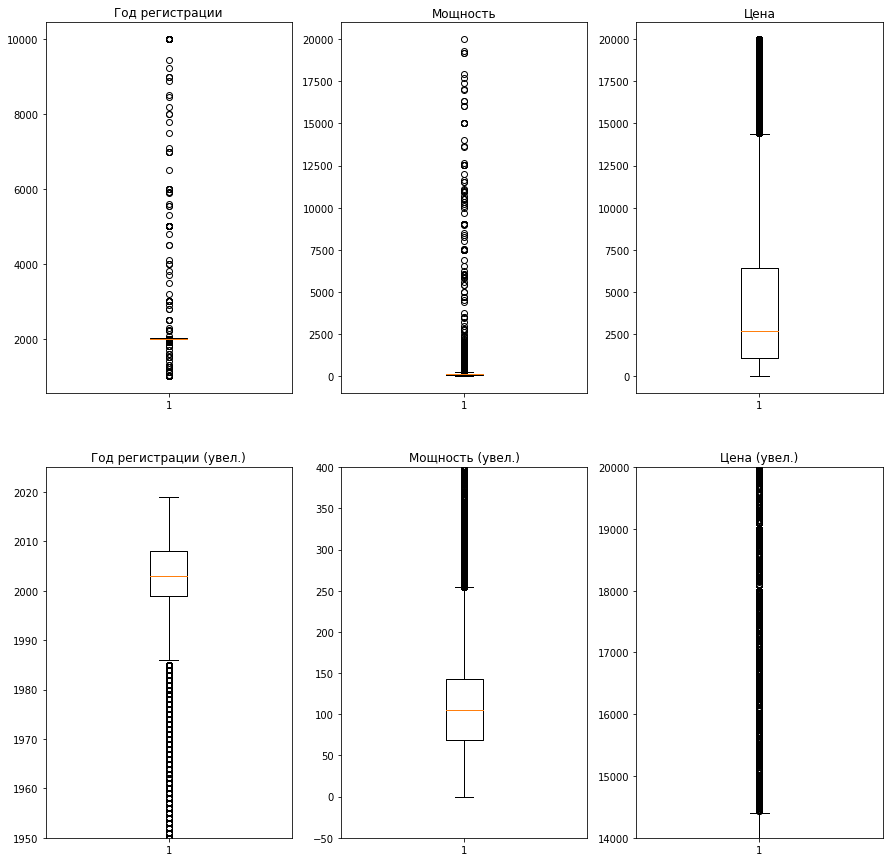

In [16]:
boxplot_plotter(data)

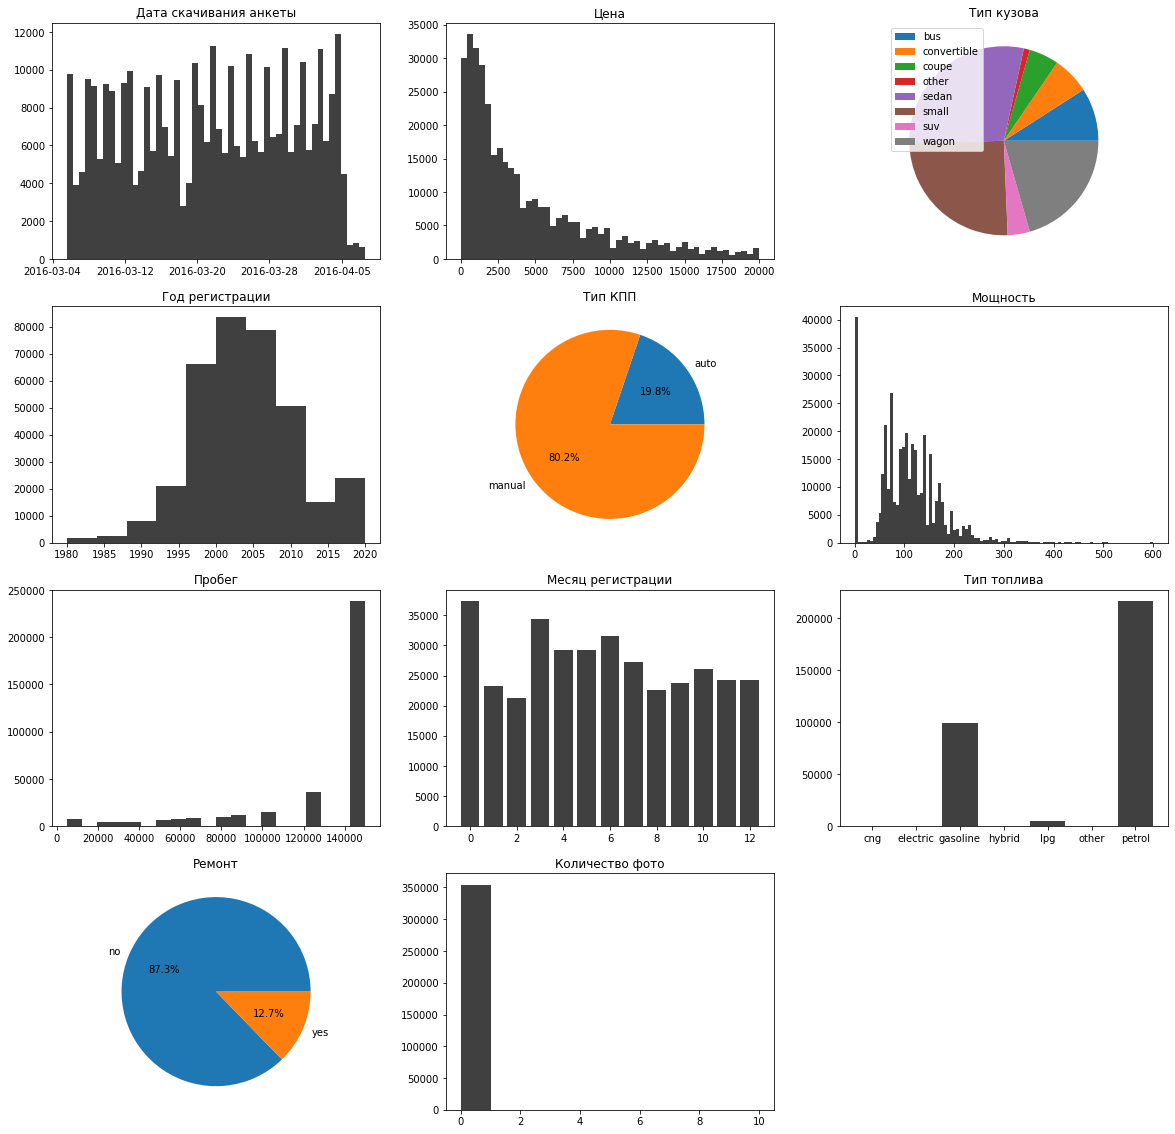

In [17]:
data_plotter(data)


<div class="alert alert-block alert-success">
<b>Успех:</b> Хороший осмотр данных


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Не хватает выводов, каждое действие должно быть подкреплено аргументами.
</div>


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Все расписал в выводах по предобработке.
</div>

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> 👍
</div>



<div class="alert alert-block alert-info">
<b>Совет:</b>  Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) 
</div>



### Удаление лишних столбцов

In [18]:
data = data.drop(
    ['PostalCode', 'NumberOfPictures', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen'], 
    axis = 1)

### Заполнение пропусков

In [19]:
data['Repaired'] = data['Repaired'].fillna('no')
data = data.fillna('unknown')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Разделение на выборки

In [22]:
data_train, data_valid_and_test = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid_and_test, test_size=0.5, random_state=12345)

In [23]:
print('Размер обучающей выборки:', data_train.shape[0])
print('Размер валидационной выборки:', data_valid.shape[0])
print('Размер тестовой выборки:', data_test.shape[0])

Размер обучающей выборки: 212621
Размер валидационной выборки: 70874
Размер тестовой выборки: 70874


### Создание кодированных датасетов

In [24]:
columns = ['VehicleType', 
           'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

encoder = OrdinalEncoder(handle_unknown = 'ignore')
encoder.fit(data_train[columns])

data_ordinal_train = encoder.transform(data_train[columns])
data_ordinal_valid = encoder.transform(data_valid[columns])
data_ordinal_test = encoder.transform(data_test[columns])

data_ordinal_train = pd.DataFrame(data_ordinal_train, columns = data_train[columns].columns)
data_ordinal_valid = pd.DataFrame(data_ordinal_valid, columns = data_valid[columns].columns)
data_ordinal_test = pd.DataFrame(data_ordinal_test, columns = data_test[columns].columns)

data_ordinal_train = data_ordinal_train.join(data_train.reset_index(drop = True).drop(columns, axis = 1))
data_ordinal_valid = data_ordinal_valid.join(data_valid.reset_index(drop = True).drop(columns, axis = 1))
data_ordinal_test = data_ordinal_test.join(data_test.reset_index(drop = True).drop(columns, axis = 1))

data_ordinal_train.info()
data_ordinal_valid.info()
data_ordinal_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212621 entries, 0 to 212620
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       212621 non-null  float64
 1   Gearbox           212621 non-null  float64
 2   Model             212621 non-null  float64
 3   FuelType          212621 non-null  float64
 4   Brand             212621 non-null  float64
 5   Repaired          212621 non-null  float64
 6   Price             212621 non-null  int64  
 7   RegistrationYear  212621 non-null  int64  
 8   Power             212621 non-null  int64  
 9   Kilometer         212621 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 16.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70874 entries, 0 to 70873
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VehicleType       70874 non-null  float64
 1   Gearbox

### Фильтрация

In [25]:
power_pivot_maker(data_train, 600)

Автомобилей мощностью выше 600 в датасете: 241


,Power
Model,
s_type,600
ypsilon,620
c2,650
matiz,671
fabia,696
500,703
cordoba,751
sandero,800
civic,903


In [26]:
pivot = price_pivot_maker(data_train, data_train['Price'].max())
display(pivot.loc[pivot['max', 'Price'] <= 1500])
price_trs = 200
print('При удалении автомобилей с ценой ниже', price_trs, 'сохраняется', 
      round(100 * data_train.loc[data_train['Price'] >= price_trs].shape[0] / data_train.shape[0], 3), '% данных')

,min,max,count
,Price,Price,Price
Model,,,
elefantino,80,820,6
lanos,0,1400,55


При удалении автомобилей с ценой ниже 200 сохраняется 95.097 % данных


#### Не кодированный датасет

In [27]:
print('До фильтрации:')
display(data_train.describe())

data_train_filtered = power_modder(data_train, 600, 5001)
data_train_filtered = iqr_filter(data_train_filtered, 'RegistrationYear')
data_train_filtered = registration_year_cutter(data_train_filtered, 2016)
data_train_filtered = price_cutter(data_train_filtered, 200)

print('После фильтрации:')
display(data_train_filtered.describe())
power_pivot_maker(data_train_filtered, 600)

print('После удаления выбросов сохранено', 
      round(100 * data_train_filtered.shape[0]/data_train.shape[0], 2), '% исходного датасета')

data_train = data_train_filtered
del data_train_filtered

До фильтрации:


,Price,RegistrationYear,Power,Kilometer
count,212621.000000,212621.000000,212621.000000,212621.000000
mean,4414.475419,2004.132945,110.190061,128187.479130
std,4512.338209,85.087369,194.820380,37922.023471
min,0.000000,1000.000000,0.000000,5000.000000
25%,1080.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6399.000000,2008.000000,141.000000,150000.000000
max,20000.000000,9999.000000,19312.000000,150000.000000


После фильтрации:


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Price,RegistrationYear,Power,Kilometer
count,190790.000000,190790.000000,190790.000000,190790.000000
mean,4664.560066,2003.142691,110.284923,128826.274962
std,4528.490509,5.741345,61.924831,36703.148319
min,200.000000,1986.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,75.000000,125000.000000
50%,2990.000000,2003.000000,105.000000,150000.000000
75%,6700.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2016.000000,600.000000,150000.000000


Автомобилей мощностью выше 600 в датасете: 6


,Power
Model,
a6,600.0
other,600.0
s_type,600.0
unknown,600.0


После удаления выбросов сохранено 89.73 % исходного датасета


#### Кодированный датасет

In [28]:
print('До фильтрации:')
display(data_ordinal_train.describe())

data_ordinal_train_filtered = power_modder(data_ordinal_train, 600, 5001)
data_ordinal_train_filtered = iqr_filter(data_ordinal_train_filtered, 'RegistrationYear')
data_ordinal_train_filtered = registration_year_cutter(data_ordinal_train_filtered, 2016)
data_ordinal_train_filtered = price_cutter(data_ordinal_train_filtered, 200)

print('После фильтрации:')
display(data_ordinal_train_filtered.describe())
power_pivot_maker(data_ordinal_train_filtered, 600)

print('После удаления выбросов сохранено', 
      round(100 * data_ordinal_train_filtered.shape[0]/data_ordinal_train.shape[0], 2), '% исходного датасета')

data_ordinal_train = data_ordinal_train_filtered
del data_ordinal_train_filtered

До фильтрации:


,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,Price,RegistrationYear,Power,Kilometer
count,212621.000000,212621.000000,212621.000000,212621.000000,212621.000000,212621.000000,212621.000000,212621.000000,212621.000000,212621.000000
mean,4.752325,0.868296,115.772511,4.936422,20.920727,0.101599,4414.475419,2004.132945,110.190061,128187.479130
std,2.384580,0.475705,73.899399,1.882551,13.294964,0.302120,4512.338209,85.087369,194.820380,37922.023471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,5000.000000
25%,4.000000,1.000000,42.000000,2.000000,9.000000,0.000000,1080.000000,1999.000000,69.000000,125000.000000
50%,5.000000,1.000000,116.000000,6.000000,24.000000,0.000000,2700.000000,2003.000000,105.000000,150000.000000
75%,7.000000,1.000000,170.000000,6.000000,33.000000,0.000000,6399.000000,2008.000000,141.000000,150000.000000
max,8.000000,2.000000,250.000000,7.000000,39.000000,1.000000,20000.000000,9999.000000,19312.000000,150000.000000


После фильтрации:


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,Price,RegistrationYear,Power,Kilometer
count,190790.000000,190790.000000,190790.000000,190790.00000,190790.000000,190790.000000,190790.000000,190790.000000,190790.000000,190790.000000
mean,4.633152,0.846811,113.422873,4.83844,20.749012,0.095671,4664.560066,2003.142691,110.284923,128826.274962
std,2.401099,0.460358,73.603684,1.89350,13.326185,0.294140,4528.490509,5.741345,61.924831,36703.148319
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,200.000000,1986.000000,0.000000,5000.000000
25%,4.000000,1.000000,42.000000,2.00000,9.000000,0.000000,1250.000000,1999.000000,75.000000,125000.000000
50%,5.000000,1.000000,116.000000,6.00000,24.000000,0.000000,2990.000000,2003.000000,105.000000,150000.000000
75%,7.000000,1.000000,170.000000,6.00000,33.000000,0.000000,6700.000000,2007.000000,143.000000,150000.000000
max,8.000000,2.000000,250.000000,7.00000,39.000000,1.000000,20000.000000,2016.000000,600.000000,150000.000000


Автомобилей мощностью выше 600 в датасете: 6


,Power
Model,
31.0,600.0
166.0,600.0
194.0,600.0
228.0,600.0


После удаления выбросов сохранено 89.73 % исходного датасета


### Разделение на features и target

In [29]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

#### Не кодированный датасет

In [30]:
data_train_features = data_train.drop('Price', axis = 1)
data_train_target = data_train['Price']
data_valid_features = data_valid.drop('Price', axis = 1)
data_valid_target = data_valid['Price']
data_test_features = data_test.drop('Price', axis = 1)
data_test_target = data_test['Price']

#### Кодированный датасет

In [31]:
data_ordinal_train_features = data_ordinal_train.drop('Price', axis = 1)
data_ordinal_train_target = data_ordinal_train['Price']
data_ordinal_valid_features = data_ordinal_valid.drop('Price', axis = 1)
data_ordinal_valid_target = data_ordinal_valid['Price']
data_ordinal_test_features = data_ordinal_test.drop('Price', axis = 1)
data_ordinal_test_target = data_ordinal_test['Price']

### Выводы по предобработке данных

Построены круговые диаграммы, гистограммы и диаграммы размаха для признаков датасета. Удалены признаки с количеством фото (в нем ошибка, там только 0), даты публицации и последнего просмотра, месяц регистрации.

В ходе предобработки данных были изучены аномалии признаков года регистрации и мощности. Года регистрации были сначала отфильрованы iqr-фильтром сверху и снизу, затем добавлена отсечка до 2016 года сверху. 

С мощностью была замечена зависимость, что после 600 сил и до 5000 сил значения преимущественно похожи на значения с ошибкой в 10 раз (пропущена десятичная запятая), поэтому их удалять я не стал, а разделил на 10. С 5000 сил зависимость та же, но на 2 знака (в 100 раз). Таким образом ни одна строка датасета не потеряна в ходе работы с признаком мощности. Более тонко можно обработать аномалии (как мне кажется) только введя таблицу соответствия модель-мощность (что крайне проблематично для 250 моделей авто). Таким образом, если выбросы будут встречаться внутри одной модели до 600 сил, их количество будет мало в общей массе (например матиз на 1500 сил). Гиперкаров в выборке не замечено, поэтому ошибки в диапазоне мощности от 1000 сил маловероятны.

Пропуски в графе ремонтов были заполнены значением "no" (ремонта не было). 

Построена сводная таблица минимальной и максимальной цены по моделям в датасете срезанная до 1500 евро. Получается, что если убрать из обучающего датасета все автомобили с ценой ниже 820 евро, ни одна модель автомобиля не будет полностью исключена из обучающего датасета, уйдут в основном аномалии целевого признака и в некоторой мере автомобили с ценой сильно ниже рыночной. Правда это приводит к потере почти 19% объема обучающей выборки.

В целом, для корректной фильтрации выбросов целевого признака, как мне кажется, недостаточно данных. 

Во-первых бывают случаи неуказанной цены или неактуально указанной цены для манипулирования сортировкой в выдаче результатов поиска на торговой площадке (продавец ставит цену 1 евро, чтобы при сортировке по цене быть в числе первых в выдаче). 

Во-вторых бывают цены существенно ниже рыночных для юридически не чистых транспортных средств (особенно аткуально для мотоциклов, но для автомобилей такое тоже случается, из личного опыта). Сервисы по продаже автомобилей не застрахованы от такого рода объявлений, за исключением аукционов (и то не в полной мере, но аукционам в данных вопросах помогает серьезная процедура проверки автомобилей при продаже). 

В-третьих бывает неадекватно низкая цена выставлена в объявлении просто потому что собственник транспортного средства просто хочет от него избавиться (налоговое бремя, отсутствие необходимости и/или сложности в эксплуатации) или собственнику просто неважно за сколько будет продано транспортное средство (также из личного опыта).

В связи с вышеизложенным мною было принято решение максимально примитивно бороться с аномалиями целевого признака, а именно, сделать отсечку снизу в 200 евро, что уберет большУю часть аномалий (как минимум нулевые цены, хотя в диапазоне до 200 евро встречаются самые разнообразные цены).

## Обучение моделей

### Catboost

In [32]:
%%time
catboost_grid_space = {'depth' : [2, 4, 6, 8, 10], 
                       'iterations' : [5, 10, 15, 20] 
                      }

model = CatBoostRegressor()

RMSE_score = make_scorer(RMSE, greater_is_better = False)

grid = GridSearchCV(estimator = model, param_grid = catboost_grid_space, cv = 2, scoring = RMSE_score)
model_grid = grid.fit(data_train_features, data_train_target, cat_features = cat_features, verbose = None)

print('Лучшие гиперпараметры:', model_grid.best_params_)
print('Лучшая оценка:', abs(model_grid.best_score_))

Learning rate set to 0.5
0:	learn: 3535.4878688	total: 76.9ms	remaining: 307ms
1:	learn: 3117.5159987	total: 117ms	remaining: 175ms
2:	learn: 2828.8673293	total: 156ms	remaining: 104ms
3:	learn: 2638.6705074	total: 186ms	remaining: 46.5ms
4:	learn: 2510.9749991	total: 204ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3550.9725102	total: 35.5ms	remaining: 142ms
1:	learn: 3167.8249044	total: 59.5ms	remaining: 89.2ms
2:	learn: 2869.7979763	total: 83.7ms	remaining: 55.8ms
3:	learn: 2655.6844302	total: 102ms	remaining: 25.5ms
4:	learn: 2541.3871698	total: 121ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3535.4878688	total: 24ms	remaining: 216ms
1:	learn: 3117.5159987	total: 50.2ms	remaining: 201ms
2:	learn: 2828.8673293	total: 74.9ms	remaining: 175ms
3:	learn: 2638.6705074	total: 94.3ms	remaining: 141ms
4:	learn: 2510.9749991	total: 112ms	remaining: 112ms
5:	learn: 2398.7662089	total: 130ms	remaining: 86.8ms
6:	learn: 2348.8317806	total: 148ms	remaining: 63.5ms
7:	learn: 2285.4

In [33]:
%%time

model_1 = CatBoostRegressor(
    iterations = int(model_grid.best_params_['iterations']), 
    depth = int(model_grid.best_params_['depth']), 
    learning_rate = None)
model_1.fit(data_train_features, data_train_target, cat_features = cat_features)

Learning rate set to 0.5
0:	learn: 3036.5929523	total: 130ms	remaining: 2.46s
1:	learn: 2400.5506780	total: 278ms	remaining: 2.5s
2:	learn: 2071.0123892	total: 399ms	remaining: 2.26s
3:	learn: 1924.3651724	total: 506ms	remaining: 2.02s
4:	learn: 1836.0520939	total: 621ms	remaining: 1.86s
5:	learn: 1790.3594093	total: 731ms	remaining: 1.71s
6:	learn: 1764.3579346	total: 838ms	remaining: 1.56s
7:	learn: 1742.7120511	total: 960ms	remaining: 1.44s
8:	learn: 1727.6932250	total: 1.07s	remaining: 1.3s
9:	learn: 1714.1733544	total: 1.2s	remaining: 1.2s
10:	learn: 1696.8963146	total: 1.3s	remaining: 1.07s
11:	learn: 1680.5556309	total: 1.42s	remaining: 945ms
12:	learn: 1670.4931478	total: 1.53s	remaining: 822ms
13:	learn: 1654.6329642	total: 1.65s	remaining: 705ms
14:	learn: 1642.0519483	total: 1.78s	remaining: 593ms
15:	learn: 1632.6068065	total: 1.89s	remaining: 473ms
16:	learn: 1626.1155600	total: 2s	remaining: 354ms
17:	learn: 1620.7859133	total: 2.11s	remaining: 235ms
18:	learn: 1615.59655

In [34]:
%time
data_valid_predict = model_1.predict(data_valid_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\nRMSE = ', round(RMSE(data_valid_target, data_valid_predict), 3))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Метрики наилучшей модели из исследованных:

RMSE =  1914.798


### RandomForestRegressor

In [35]:
%%time
random_forest_grid_space = {'max_depth' : [2, 5, 8, 10], 
                            'min_samples_split' : [5, 10, 15, 20] 
                           }

model = RandomForestRegressor()

RMSE_score = make_scorer(RMSE, greater_is_better = False)

grid = GridSearchCV(estimator = model, param_grid = random_forest_grid_space, cv = 2, scoring = RMSE_score)
model_grid = grid.fit(data_ordinal_train_features, data_ordinal_train_target)

print('Лучшие гиперпараметры:', model_grid.best_params_)
print('Лучшая оценка:', abs(model_grid.best_score_))

Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 10}
Лучшая оценка: 1837.300256364043
CPU times: user 4min 50s, sys: 705 ms, total: 4min 51s
Wall time: 4min 51s


In [36]:
%%time

model_2 = RandomForestRegressor(max_depth = int(model_grid.best_params_['max_depth']), 
                                min_samples_split = int(model_grid.best_params_['min_samples_split']), 
                                random_state = 12345)
model_2.fit(data_ordinal_train_features, data_ordinal_train_target)


CPU times: user 26.4 s, sys: 39.9 ms, total: 26.4 s
Wall time: 26.5 s


RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=12345)

In [37]:
%time
data_ordinal_valid_predict = model_2.predict(data_ordinal_valid_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\nRMSE = ', round(RMSE(data_ordinal_valid_target, data_ordinal_valid_predict), 3))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Метрики наилучшей модели из исследованных:

RMSE =  2084.628


### LightGBM

In [38]:
%%time

lightgbm_grid_space = {'max_depth' : [2, 3], 
                       'num_leaves' : [4, 8],
                      }

model = lightgbm.LGBMRegressor()

RMSE_score = make_scorer(RMSE, greater_is_better = False)

grid = GridSearchCV(estimator = model, param_grid = lightgbm_grid_space, cv = 2, scoring = RMSE_score)
model_grid = grid.fit(data_ordinal_train_features, data_ordinal_train_target)

print('Лучшие гиперпараметры:', model_grid.best_params_)
print('Лучшая оценка:', abs(model_grid.best_score_))

Лучшие гиперпараметры: {'max_depth': 3, 'num_leaves': 8}
Лучшая оценка: 1883.341095901697
CPU times: user 8min 36s, sys: 7.32 s, total: 8min 44s
Wall time: 8min 48s


In [39]:
%%time

model_3 = lightgbm.LGBMRegressor(max_depth = int(model_grid.best_params_['max_depth']), 
                                 num_leaves = int(model_grid.best_params_['num_leaves']), )
model_3.fit(data_ordinal_train_features, data_ordinal_train_target)

CPU times: user 1min 13s, sys: 1.14 s, total: 1min 14s
Wall time: 1min 15s


LGBMRegressor(max_depth=3, num_leaves=8)

In [40]:
%time
data_ordinal_valid_predict = model_3.predict(data_ordinal_valid_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\nRMSE = ', round(RMSE(data_ordinal_valid_target, data_ordinal_valid_predict), 3))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs
Метрики наилучшей модели из исследованных:

RMSE =  2117.446


### Тестирование наилучшей модели

In [41]:
%%time
data_test_predict = model_1.predict(data_test_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\nRMSE = ', round(RMSE(data_test_target, data_test_predict), 3))

Метрики наилучшей модели из исследованных:

RMSE =  1924.146
CPU times: user 99 ms, sys: 3.73 ms, total: 103 ms
Wall time: 173 ms


## Анализ моделей

В процессе работы над проектом было изучено 3 модели обучения:
- градиентный бустинг с помощью библиотеки "catboost";
- градиентный бустинг с помощью библиотеки "LightGBM";
- регрессия случайным лесом.

Время выполнения и значения RMSE лучших моделей указаны в таблице ниже.

|  |Catboost|LightGBM|RandommForestRegressor| 
|:-|:-:|:-:|:-:|
|RMSE|1914.798|2117.720.446|2084.628|
|Время обучения модели|3.52 сек|1 мин 15 сек|26.5 сек|
|Время предсказания модели|6.68 микросек|8.34 микросек|8.34 микросек|
|Время поиска гиперпараметров|59 сек|8 мин 48 сек|4 мин 51 сек|

## Выводы

### Предобработка данных

В процессе работы был изучен датасет с данными о проданных автомобилях. Был произведен графический анализ данных. Категориальные пропуски были заполнены преимущественно новой категорией "undefined" (не определен). Пропуски в графе "repaired" были заполнены значением "no", предполагается, что отсутствие указанного факта ремонта значит, что ремонта не было. Графы с датами приведены к типу datetime.

Создан дублирующий датасет, в котором только категориальные признаки были подвергнуты кодированию с помощью ordinary encode. Заполнение пропусков дублирующего датасета производилась в точности также как и в основном. Оба датасета разбиты на тренировочную и валидационную выборки. В тренировочных датасетах удалены строки датасета с выбросами в графе "registration year", фильтрации подвергнулись данные, значения признака в которых не входили в интервал [q1 - 1.5 * iqr, q3 + 1.5 * iqr], затем произведена отсечка по 2016 году. Ошибки в графе "power" были исправлены исходя из допущения, что от 600 сил до 5000 сил ошибка была в 10 раз, выше 5000 в 100 раз. Исследована мощность посредством построения сводной таблицы максимальных мощностей по модели и сопоставлению реальных показателей для модели с имеющимися в датасети. Убраны строки тренировочного датасета с ценой менее 200 евро.

Таким образом были получены два тренировочных два валидационных датасета и два тестовых. Из валидационного и тестового не производилось удаления каких-либо строк (в отличие от тренировочного), разница комплектов датасетов заключается лишь в том, что один комплект был закодирован числовыми значениями признаков для моделей обучения, которые не могут работать с не числовыми признаками.

### Обучение моделей

Произведено обучение трех типов моделей: catboost, random forest regressor и lightgbm. Для всех моделей был произведен поиск оптимальных гиперпараметров по критерию минимизации RMSE. Для наилучших моделей каждого типа рассчитано время обучения.

### Анализ моделей

Гиперпараметры наилучшей модели catboost:
- depth = 10;
- iterations = 20.

Гиперпараметры наилучшей модели random forest regressor:
- max_depth = 10;
- min_samples_split = 5.

Гиперпараметры наилучшей модели lightgbm:
- max_depth = 3;
- num_leaves = 8.

Время выполнения и значения RMSE моделей на валидационной выборке указаны в таблице ниже.

|  |Catboost|LightGBM|RandommForestRegressor| 
|:-|:-:|:-:|:-:|
|RMSE|1914.798|2117.720.446|2084.628|
|Время обучения модели|3.52 сек|1 мин 15 сек|26.5 сек|
|Время предсказания модели|6.68 микросек|8.34 микросек|8.34 микросек|
|Время поиска гиперпараметров|59 сек|8 мин 48 сек|4 мин 51 сек|

### Итог

Наилучшая модель - catboost с гиперпараметрами: depth = 10, iterations = 20. RMSE модели на тестовой выборке - 1924.146, время обучения модели - 3.52 сек, время предсказания модели - 173 милисек. 